In [1]:
import gym
import numpy as np
import random
import torch
from itertools import count


In [2]:
env = gym.make('Pendulum-v0')

In [3]:
env.action_space

Box(1,)

In [4]:
env.observation_space

Box(3,)

In [182]:
env.reset()
for i in range(500):
    env.render()
    env.step(env.action_space.sample())
env.close()

In [5]:
env.close()
env.reset()

array([-0.52775357,  0.        ])

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

In [5]:
class OUNoise:
    """docstring for OUNoise"""
    def __init__(self, action_dimension, mu=0, theta=0.15, sigma=0.2):
        self.action_dimension = action_dimension
        self.mu = mu
        self.theta = theta
        self.sigma = sigma
        self.state = np.ones(self.action_dimension) * self.mu
        self.reset()

    def reset(self):
        self.state = np.ones(self.action_dimension) * self.mu

    def noise(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(len(x))
        self.state = x + dx
        return self.state

In [6]:
from collections import deque

In [7]:
class Memory():
    def __init__(self, capacity=10000, short_capacity=2000):
        self.capacity = capacity
        self.memory = deque(maxlen=self.capacity)
        self.short_memory = deque(maxlen=short_capacity)
        
    def push(self, old_state, action, reward, new_state, final):
        self.short_memory.append([old_state, action, reward, new_state, final])
        
    def commit(self, final=True): 
        
        self.short_memory[-1][-1] = final
        
#         R = self.short_memory[-1][2]
#         for i in range(len(self.short_memory) - 1):
#             R = self.short_memory[-2 -i][2] + R*0.99
#             self.short_memory[-2 -i][2] = R
        
        self.memory.extendleft(self.short_memory)

                
#         self.memory = self.memory[-self.capacity:]
        self.short_memory.clear()

In [11]:
class Actor_net(torch.nn.Module):
    def __init__(self):
        super(Actor_net, self).__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(6, 64),
            torch.nn.ReLU(),
#             torch.nn.Dropout(p=0.2),
            
#             torch.nn.Linear(16, 16),
#             torch.nn.ReLU(),
#             torch.nn.Dropout(p=0.2),
            
            torch.nn.Linear(64, 1),
#             torch.nn.Tanh(),
#             torch.nn.Sigmoid(),
        )
    
    def forward(self, x):
        return self.model(x).div(30).clamp(-1, 1)
    
class Qritic_net(torch.nn.Module):
    def __init__(self):
        super(Qritic_net, self).__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(6, 64),
            torch.nn.ReLU(),
#             torch.nn.Dropout(p=0.2),
            
#             torch.nn.Linear(16, 16),
#             torch.nn.ReLU(),
#             torch.nn.Linear(32, 32),
#             torch.nn.LeakyReLU(),
        )
        
        self.head = torch.nn.Sequential(
            torch.nn.Linear(64 + 1, 64),
            torch.nn.ReLU(),
#             torch.nn.Dropout(p=0.2),
            
            torch.nn.Linear(64, 1),
        )
    
    def forward(self, state, actions):
        out = self.model(state)
        out = torch.cat((out, actions), dim=1)
        out = self.head(out)
        return out

policy_actor, policy_critic = Actor_net().to(device), Qritic_net().to(device)
target_actor, target_critic = Actor_net().to(device), Qritic_net().to(device)

target_actor.load_state_dict(policy_actor.state_dict())
target_critic.load_state_dict(policy_critic.state_dict())

critic_optim = torch.optim.Adam(policy_critic.parameters(), lr=0.01)
actor_optim = torch.optim.Adam(policy_actor.parameters(), lr=0.01)
# optim = torch.optim.SGD(policy_net.parameters(), lr=0.001)

# from torch.optim.lr_scheduler import StepLR
# scheduler = StepLR(optim, step_size=100, gamma=0.84)    

In [19]:
# %%prun
# env = gym.make('CartPole-v0')
env._max_episode_steps = 200

EPS = 2
EPS_MIN = 0.2
GAMMA = 0.99999
c = 0

noise = OUNoise(1)

def get_model_action(model, state, device, train=True):
    global EPS, EPS_MIN, GAMMA, noise
    EPS = EPS * GAMMA
    EPS = max(EPS, EPS_MIN)
    
#     if random.random() < EPS:
#         action = random.random() * 2
#         action -= 1
#         return [action]
    
    if train and random.random() < 0.2:
        return [0]
    
    with torch.no_grad():
        model.eval()
        model_output = model(torch.FloatTensor(state).to(device).unsqueeze(0)).cpu().detach().numpy()
        action = model_output[0]
#         action = np.clip(action, -1.0, 1.0)
        
#         action += EPS * noise.noise()
        action += (random.random() * 4 - 2)
        action = np.clip(action, -1.0, 1.0)
#             print(state, model_output, action)
        
    global c
    c += 1
    if c < 30:
        print(action)
        
    return action
    
    if train:
        
        action = np.clip(action, -1, 1)
        noise = (random.random() * 2) -1
        noise = noise * EPS  * 2
        action = action + noise
        action = np.clip(action, -1, 1)

    
    return action

def train(memory, device):
    memory = memory.memory
    try:
        memory = random.sample(memory, 64)
    except ValueError:
        return

#     s0 = [x[0] for x in memory]
#     a = [x[1] for x in memory]
#     r = [[x[2]] for x in memory]
#     s1 = [x[3] for x in memory]
#     done = [1. if x[4] else 0. for x in memory]
    
    s0, a, r, s1, done = zip(*memory)


    s0 = torch.FloatTensor(s0).to(device)
    s1 = torch.FloatTensor(s1).to(device)
    a = torch.FloatTensor(a).to(device)
    r = torch.FloatTensor(r).unsqueeze(1).to(device)
    done = torch.FloatTensor(done).to(device)
    
    policy_actor.train()
    policy_critic.train()
    target_critic.train()
    target_actor.train()

    
    y = target_critic(s1, target_actor(s1)).mul(0.8).add(r)
#     y = target_critic(s1, target_actor(s1)) * 0.999 * (1.0 - done) + r
    target = policy_critic(s0, a)
#     loss = (y.detach() - target).view(-1).pow(2).mean()
    critic_loss = torch.nn.functional.smooth_l1_loss(y.detach(), target)
#     critic_loss = (y.detach() - target).pow(2).mean()
    
#     print('s0', s0)
#     print('a', a)
#     print('r', r)
#     print('s1', s1)
    
#     print('y', y)
#     print('target', target)
#     print('loss', critic_loss.item())
#     assert False

    policy_critic.zero_grad()
#     critic_optim.zero_grad()

    critic_loss.backward()
    critic_optim.step()
    
    policy_actions = policy_actor(s0)
    q_values = policy_critic(s0, policy_actions)
    

    
    actor_loss = q_values.mean().mul(-1)
    
    policy_actor.zero_grad()
#     actor_optim.zero_grad()
    actor_loss.backward()
    actor_optim.step()
    
#     print()
#     print('policy_actions', policy_actions)
#     print('q_values', q_values)
#     print('loss', actor_loss.item())
#     assert False
    
    def soft_update(target_model, source_model, tau=0.01):
        for target_param, source_param in zip(target_model.parameters(), source_model.parameters()):
                target_param.data.copy_(tau*source_param.data + (1.0-tau)*target_param.data)
                
#     soft_update(target_actor, policy_actor)
#     soft_update(target_critic, policy_critic)
        
#     scheduler.step()

memory = Memory(capacity=100000)  
len_mem = []
cum_reward_mem = []

try:
    for episode in range(1000000):
        old_state = env.reset()
        state, *_ = env.step([0])
        shift_state = np.concatenate((state, state - old_state))
        
        
        cum_reward = []
        for i in count():
#             env.render()
            

            action = get_model_action(policy_actor, shift_state, device, train=True)
            old_state = state
            old_shift_state = shift_state
            state, reward, done, info = env.step(action)
            shift_state = np.concatenate((state, state - old_state))
            
#             reward = max(-0, state[0] + 0.5)
#             reward = state[0] + 0.5
#             reward *= 10
#             reward /= 10
#             reward += 5
#             reward = -abs(reward + 10)
#             reward = -reward
#             if reward >= 0:
#                 reward /= 5

#             reward = -(abs(state[0] + 0.5))
#             print(state, reward)

            cum_reward.append(reward)
            
#             if state[0] + 0.5 > 0.7:
#                 done = True

            
            if not done:
                memory.push(old_shift_state, action, reward, shift_state, False)
            else:
                env.close()
                len_mem.append(i)
                cum_reward_mem.append(np.sum(cum_reward))

#                 if state[0] + 0.5 >= 0.7:
#                     reward = 1000
#                     final = True
#                 else:
#                     final = False
                
                memory.push(old_shift_state, action, reward, shift_state, True)
                memory.commit()
                break

        
        if episode % 100 == 0:
            print('Episode {:3d}: {:10.3f} iterations, eps={:6.6f}'.format(episode, np.mean(cum_reward_mem[-100:]), EPS))
        
        for _ in range(1):
            train(memory, device)
            
        if episode % 10 == 0:
            target_actor.load_state_dict(policy_actor.state_dict())
            target_critic.load_state_dict(policy_critic.state_dict())

except KeyboardInterrupt:
    env.close()

[ 0.13294744]
[-1.]
[ 1.]
[-0.51185668]
[ 1.]
[ 0.49521565]
[ 1.]
[ 0.99291939]
[-1.]
[-0.54430676]
[-0.13813353]
[ 1.]
[-0.11760628]
[ 0.748245]
[ 0.54649973]
[-1.]
[-0.60897839]
[ 0.60976398]
[-1.]
[-1.]
[-1.]
[-0.55596924]
[-1.]
[ 0.33035588]
[-1.]
[ 0.57192397]
[ 0.38665044]
[-1.]
[ 0.70107174]
Episode   0:  -1602.045 iterations, eps=1.996024
Episode 100:  -1238.053 iterations, eps=1.635840
Episode 200:  -1241.439 iterations, eps=1.340651


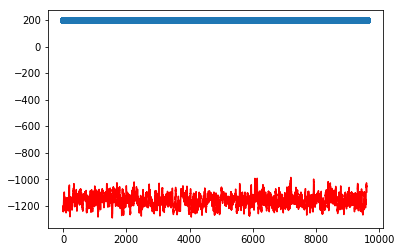

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd



plt.figure()
plt.plot(len_mem, 'o')
plt.plot(pd.Series(cum_reward_mem).rolling(20).mean().dropna().values, color='red')

In [14]:
try:
#     env.seed = random.randint(0, 100000)
    env._max_episode_steps = 500
    
    
    old_state = env.reset()
    state, *_ = env.step([0])
    shift_state = np.concatenate((state, state - old_state))
    for t in count():
        
        if t % 500 == 0:
            print(t)
        
        env.render()
        
        global EPS
        EPS = 0.0
        
        policy_actor.eval()
        action = get_model_action(policy_actor, shift_state, device, train=False)
        old_state = state
        old_shift_state = shift_state
        state, reward, done, info = env.step(action)
        shift_state = np.concatenate((state, state - old_state))
#         state, reward, done, info = env.step(action)

        print(action, reward, state)

        if done:
            env.close()
            
            break

    print(t)
    assert False
except KeyboardInterrupt:
    pass
finally:
    env.close()
    print(t)

0
[-0.25179803] -2.20529500383 [ 0.03373095 -0.99943095 -1.90746861]
[ 1.] -2.72739394809 [-0.09148664 -0.9958063  -2.50704182]
[ 1.] -3.3931364281 [-0.24431146 -0.96969681 -3.10389655]
[-0.91984951] -4.26795469263 [-0.43069877 -0.90249574 -3.96914659]
[ 1.] -5.64092338871 [-0.62103914 -0.78377955 -4.49601839]
[ 1.] -7.04389025504 [-0.79363488 -0.60839435 -4.93385306]
[-0.99879956] -8.6232270203 [-0.92975944 -0.3681676  -5.53996875]
[ 1.] -10.7128910261 [-0.99561031 -0.0935955  -5.66609445]
[ 0.02237198] -12.4999134584 [-0.98144972  0.19171972 -5.73293528]
[ 1.] -11.9823600962 [-0.89387925  0.4483078  -5.4391455 ]
[ 0.35474348] -10.1233931899 [-0.75354618  0.65739497 -5.04970312]
[ 0.14252567] -8.42689140847 [-0.58645556  0.8099814  -4.53527804]
[ 0.46893454] -6.88597889152 [-0.42032488  0.90737368 -3.85745181]
[ 0.0661912] -5.50641763204 [-0.27198355  0.9623019  -3.16699287]
[-0.44913626] -4.41182523694 [-0.14926198  0.98879769 -2.51263689]
[ 0.25367188] -3.5919256603 [-0.06313045  0.

[-0.70004284] -13.5594043209 [-0.95375828  0.30057468 -6.20960038]
[ 1.] -11.9014972717 [-0.8270238   0.56216691 -5.83416937]
[ 1.] -9.87968662997 [-0.65233832  0.75792791 -5.26254418]
[-1.] -7.97550523606 [-0.45151327  0.89226441 -4.84409825]
[ 0.22856534] -6.50514982889 [-0.25846207  0.96602141 -4.14061515]
[ 0.17778993] -5.07155371158 [-0.09182876  0.99577481 -3.3894306 ]
[-1.] -3.91457695935 [ 0.04765361  0.99886392 -2.79259949]
[-0.0875501] -3.09977759014 [ 0.14993336  0.9886961  -2.05658407]
[-1.] -2.44119298864 [ 0.22189157  0.97507135 -1.46506199]
[ 0.50292242] -2.0294167075 [ 0.25386103  0.9672407  -0.65832012]
[ 0.87306893] -1.77102885516 [ 0.24426963  0.96970735  0.19807075]
[-1.] -1.75797834943 [ 0.20650232  0.97844611  0.77535126]
[-0.3053357] -1.91742708372 [ 0.13442146  0.99092425  1.46338549]
[-1.] -2.27715014966 [ 0.0319952   0.99948802  2.05657868]
[-1.] -2.79184367143 [-0.10063841  0.99492307  2.6561947 ]
[-1.] -3.50080162404 [-0.26039222  0.96550292  3.252387  ]
[-1

[-1.] -1.81417761333 [ 0.28344082  0.95898973 -0.45867693]
[-1.] -1.66919546683 [ 0.27813496  0.96054201  0.11056536]
[-1.] -1.663600183 [ 0.24527497  0.96945355  0.68097187]
[-1.] -1.79768277706 [ 0.18384845  0.9829546   1.25806203]
[-0.28728753] -2.07906257819 [ 0.08718016  0.99619256  1.95218485]
[-1.] -2.58289071062 [-0.04016469  0.99919307  2.54932927]
[-1.] -3.24613817803 [-0.19632807  0.98053826  3.14872408]
[-0.50151157] -4.11896478404 [-0.37839037  0.92564611  3.80890104]
[-0.35822719] -5.288006413 [-0.57329919  0.8193461   4.44940155]
[-1.] -6.73888811211 [-0.7553725   0.65529565  4.91391113]
[-1.] -8.30607207041 [-0.89966061  0.43658995  5.25538286]
[-1.] -9.9978635906 [-0.9838144   0.17919046  5.43282532]
[-1.] -11.7226215246 [-0.99588981 -0.09057308  5.41721817]
[-0.35535613] -12.2427135607 [-0.93747375 -0.34805598  5.29598494]
[ 0.53237242] -10.5673601779 [-0.81893901 -0.57388057  5.11479882]
[ 1.] -9.01981865149 [-0.65775949 -0.75322802  4.8343884 ]
[ 1.] -7.57598893378 

[ 1.] -12.4811643838 [-0.93451318 -0.35592853  5.66666781]
[ 1.] -10.9276473447 [-0.80126276 -0.59831262  5.54972141]
[ 1.] -9.33193634222 [-0.61851657 -0.78577176  5.25098695]
[ 1.] -7.76536283139 [-0.41347795 -0.91051413  4.81165813]
[ 0.92753804] -6.30434173115 [-0.21127123 -0.97742747  4.26790323]
[ 0.01759297] -5.00298480775 [-0.03599401 -0.99935201  3.53747157]
[-0.30666363] -3.83326472511 [ 0.100924   -0.99489414  2.74195802]
[ 1.] -2.91285208696 [ 0.20688059 -0.9783662   2.14578742]
[ 1.] -2.31760365852 [ 0.28258332 -0.95924276  1.56201277]
[ 0.62480956] -1.89383146631 [ 0.32716436 -0.94496745  0.93630214]
[ 0.29573649] -1.61914773484 [ 0.33998231 -0.94043183  0.27193702]
[-0.62307] -1.50571009748 [ 0.31509402 -0.94906046 -0.52684735]
[ 0.38328958] -1.59100530559 [ 0.25852816 -0.96600372 -1.18114926]
[ 1.] -1.85477280009 [ 0.17284326 -0.98494934 -1.75565205]
[-0.10267174] -2.26007636658 [ 0.04820872 -0.99883728 -2.50976482]
[ 0.56442606] -2.94842662553 [-0.1102594  -0.99390285 

AssertionError: 

In [20]:
model = policy_net

In [21]:
model.to('cpu')

Qnet(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace)
    (2): Linear(in_features=32, out_features=3, bias=True)
  )
)

In [22]:
torch.save(model, 'cart.torch')

/usr/local/lib/python3.5/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type Qnet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [23]:
model = torch.load('cart.torch')

In [24]:
model.to(device)

Qnet(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace)
    (2): Linear(in_features=32, out_features=3, bias=True)
  )
)

In [25]:
policy_net = model